# Final Project
This project aims to use similar-item sets techniques to find plagiarised news articles and classify them according to genres using unsupervised machine learning methods.
Furthermore, it is also examined to what extent clustering can be used to find plagiarised articles and how it compares with standard techniques such as minhashing and lsh. 

In [1]:
import os
import mmh3
import numpy as np
import collections
import pandas as pd
from datasketch import MinHash, MinHashLSH
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import LdaMulticore, LdaModel
from gensim import matutils as genmath, corpora, models
from itertools import tee
import pickle
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE


DATA_SIZE=50000

### Utilities

In [2]:
#################### Utilities ######################
#hashes a list of strings
def listhash(l,seed):
	val = 0
	for e in l:
		val = val ^ mmh3.hash(e, seed)
	return val 

''' Extension of standard pairwise function to 3-pairwise from the py standard lib'''
def three_pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    # three_pairwise('ABCDEFG') --> ABC BCD CDE DEF EFG FG
    a, b, c = tee(iterable, 3) ## Create three iterators
    next(b, None) ## Advance the second
    next(c, None) ## Advance the third
    next(c, None) ## Advance the third once again. This ensures the third iterator starts at the third element and that we can create the 3-tuple
    return zip(a, b, c) ### Zip everything (1 elem, 2 elem, and 3 elem) concurrently.

''' Tokenize data and clean using NLTK package'''
stop = set(stopwords.words('english'))
def clean(text):

    tokens = word_tokenize(text)
    # Remove the punctuations, lower tokens and remove stopword
    tokens = [word.lower() for word in tokens if word not in stop and len(word) > 2]
   
    return tokens

def stored_pickled_pairs(pairs, filename):
    with open(f"{filename}.pickle", "wb") as handle:
        pickle.dump(pairs, handle, pickle.HIGHEST_PROTOCOL)

### Data preprocessing

In [3]:
''' Load DATA_SIZE amount of data/news articles'''
ROOT_DIR = os.path.abspath(os.curdir)
data = pd.read_csv(ROOT_DIR+"//data//articles1.csv")
data_content = data[:DATA_SIZE]["content"] #we are only interested in the content in each news

***Only run the below cell for hashing. Clustering has its own cleaning cell in its own section.***

In [4]:
''' Clean data '''
cleaned_docs=[clean(data) for data in data_content]

''' Create 3-pair shingles'''
def shingle_docs(doc, k=1000):
    
    three_tup=list(three_pairwise(doc))
    three_tup=[elem for elem in three_tup if len(elem)==3]
    return three_tup

''' Listhash a doc, represented by a list of shingles (3-wise) '''
def hash_doc(doc):
    seed=1
    return np.array(sorted([listhash(shingle, seed) for shingle in doc]))

''' Shingle the entire dataset '''
shingled_docs = list(map(shingle_docs, cleaned_docs))

## Minhashing own implementation
We start by rolling our own implementation of minhash+lsh.
We encountered some key challenges in the process. The biggest being the time consumption a naive implementation of the algorithm resulted in. 
We attempted to speed up the code by using only a single hash function. However, this came at the cost of reduced accuracy (outputting dissimilar documents).
As a compromise we used a bottom-k technique from http://web.eecs.utk.edu/~jplank/plank/classes/cs494/494/notes/Min-Hash/index.html such that only a single hash function is used but instead of taking the minhash we take the k smallest hashes. However, as we shall see later, this did not result in very good results either.

In [5]:
seed=1
hashed_shingles=list(map(hash_doc, shingled_docs))

print(len(hashed_shingles))
hashed_shingles=[lst for lst in hashed_shingles if len(lst)>100] ## we discard documents that have fewer than 100 shingles

sig_m=np.array(hashed_shingles)
print(sig_m.shape)

50000
(43985,)


C:\Users\hasee\AppData\Local\Temp\ipykernel_18716\1460483552.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sig_m=np.array(hashed_shingles)


In [6]:
lens=min([len(x) for x in sig_m])
print(lens)
num_docs=sig_m.shape[0]
for i in range(num_docs):
    sig_m[i]=sig_m[i][:lens]
sig_m=np.stack(sig_m).T
sig_m.shape

101


(101, 43985)

We get a signature matrix of size (101, 43985). Some documents have to be removed as they are too small therefore we have < 50000 documents in the signature matrix. More on this in the report.

### LSH implementation

In [7]:
''' Jaccard similarity'''
def jaccard(s1, s2):
    return len(s1 & s2) / len(s1 | s2)

''' Implementation of LSH, dividing signature matrix into b band with r rows each'''
def LSH(sig_m, b, r):
    b=20
    r=5
    #b*r=num_hash_funcs

    sim_hashes=[]
    start=0
    for i in range(b):
        sim_hashes.append([listhash(col, seed=i) for col in sig_m[start:start+r,:].T])
        start=i+r

    return sim_hashes

''' Find candidate pairs by checking to see if the hashes match.
Then we check to see that the Jaccard similarity b/w each pair of docs is atleast t. If so, we consider it a candidate pair otherwise not '''
def get_cand_pairs(sim_hashes, t):
    cand_pairs=set()
    for L in sim_hashes:
        dups = collections.defaultdict(list)
        for i, e in enumerate(L):
            dups[e].append(i)
        for _, v in sorted(dups.items()):
            if len(v) >= 2:
                cand_pairs.add(tuple(v))
    cand_pairs=list(cand_pairs)
    filtered_cand_pairs = [pair for pair in cand_pairs if (jaccard(set(sig_m[:, pair[0]]), set(sig_m[:, pair[1]])) > t)]
    return filtered_cand_pairs
   

In [8]:
''' Choosing parameters for LSH  
Chosen to get a threshold of 0.55 '''
b=20
r=5
sim_hashes = LSH(sig_m, b=b, r=r)
pairs1=get_cand_pairs(sim_hashes, t=(1/b)**(1/r)) ## threshold = 0.55
# print(sig_m.shape)

In [9]:
''' Store pairs as pickle for easy retrieval later '''
# print(len(pairs1))
# stored_pickled_pairs(pairs1, "pairs1")

' Store pairs as pickle for easy retrieval later '

In [10]:
len(pairs1)

36

As we can see, we only get about 36 pairs which as we shall see later is not that many. We look at a pair to see how similar they are.

In [12]:
pairs1[0]

(38900, 38912)

In [13]:
data_content[38900]

'Atlanta (CNN) Weather always plays a factor in holiday travel.  Where will this year’s travel trouble lie?  AAA projects that 48. 7 million Americans will travel more than 50 miles for Thanksgiving this week.  That’s a 1. 9% increase from last year, and the most since 2007. Nearly 90% of travelers,  43. 5 million, will be driving to their destinations.  Whether you’re hitting the roadway or the busy skies, here’s a look at this year’s travel weather, starting with Wednesday. Airport Delays, A storm system stretching from the Great Lakes to the Gulf Coast will bring mainly rain, but a bit of snow is possible in the Upper Midwest to the western Great Lakes. Light to moderate delays are possible due to rain in Chicago, Memphis, and perhaps Houston. Light snow on the northern side of the storm could lead to delays in Minneapolis early in the day, with a   mix causing problems in Detroit by the afternoon and evening. A storm system exiting the northeast will have some lingering strong wind

In [14]:
data_content[38912]

' (CNN)  Donald Trump said a conversation with Ret. Marine Corps Gen. James Mattis gave him a new perspective on waterboarding, a torture tool he has pledged to reinstate. ”General Mattis is a strong, highly dignified man. I met with him at length and I asked him that question. I said, ’What do you think of waterboarding? ’” Trump told The New York Times on Tuesday. ”He said    I was surprised    he said, ’I’ve never found it to be useful.’ He said, ’I’ve always found, give me a pack of cigarettes and a couple of beers and I do better with that than I do with torture. ’” Donald Trump on waterboarding: ’Fight fire with fire’ Trump added, ”I’m not saying it changed my mind. Look, we have people that are chopping off heads and drowning people in steel cages and we’re not allowed to waterboard. But I’ll tell you what, I was impressed by that answer.” Trump is considering Mattis to serve as his secretary of defense. The   said he would be influenced by Americans’ views of waterboarding. ”It

As can be seen the articles are not that similar apart from being from the same news publication (CNN).
We will not analyze the performance further as we get better results using the package version as seen in the following sections. It is unclear why performance is slow for this version but probably it shows the limits of using a single hash function. 

## Minhashing using package
Here we use the package version from DataSketch

In [151]:
'''num_perm is the number of permutations we want for the MinHash algorithm ,the higher the permutations the longer the runtime.
   min_dict1 maps each documents with the form of shingles to min hash signatures. We loop through all the set representations of 
   questions and calculate the signatures and store them in the min_dict1 dictionary'''
num_perm = 200
min_dict1 = {}
count3 = 0
for val in tqdm(shingled_docs):
    m = MinHash(num_perm=num_perm)
    for shingle in val:
        a= []
        for i in shingle: 
            i.encode('utf8')
            a.append(i)
        data1 = str(['_'.join(a)])

        m.update(data1.encode('utf8'))
    min_dict1["m{}".format(count3)] = m
    count3+=1

100%|████████████████████████████████████| 50000/50000 [04:19<00:00, 192.51it/s]


In [152]:
'''We set the Jaccard similarity threshold as a parameter in MinHashLSH. We loop through the signatures or keys 
   in the min_dict dictionary ,Datasketch stores these in a dictionary format, where the key is a document
   and the value is other documents deemed similar based on the threshold. '''        
lsh = MinHashLSH(threshold=0.9, num_perm=num_perm)
for key in tqdm(min_dict1.keys()):
    lsh.insert(key,min_dict1[key]) # insert minhash data structure

100%|██████████████████████████████████| 50000/50000 [00:04<00:00, 10969.23it/s]


In [153]:
''' This function works with the dictionary output of the LSH to to output candidate pairs. '''
def create_cand_pairs():
    big_list = []
    for query in min_dict1.keys():
        bucket = lsh.query(min_dict1[query])
        if len(bucket)==1:
            big_list.append([bucket[0],"None"])
        if len(bucket)>1:
            first_val = bucket[0]
            for val in bucket[1:]:
                second_val = val
                big_list.append([first_val,second_val])
    return big_list

 We found that there are so many repetitive pairs so that we have to remove those repetitive pairs

In [154]:
cand_pairs = create_cand_pairs() #Create candidate pairs.
pairs2 = [i for i in cand_pairs if i[1] != 'None'] #Remove pairs contain "None".

#Create set to store unique candidate pairs.
pair_set = set()
for pair in pairs2:
    pair_set.add(tuple(pair))

candidate_pairs=list(pair_set)

In [155]:
print(len(candidate_pairs))

191


As can be seen we get 191 pairs. Next, we look at two articles from a pair to assess the similarity.

In [17]:
''' Load the stored tfidf matrix '''
with open("pairs2.pickle", "rb") as handle:
    candidate_pairs = pickle.load(handle)

In [23]:
data_content[int(candidate_pairs[5][0][1:])]

'’’ ’Radiology has always been an area at the cutting edge of digitization. ’ ”From virtual reality to machine learning, there are ways to apply some of the biggest concepts in technology right now to what’s happening in the medical field.” ”We’ll be at the Radiological Society of North America’s conference in Chicago for the next few days, checking out all the   technology coming on the scene. ” ”Here are some of the innovations and trends we’re looking forward to seeing in action. ” ’In the near future, we might be using a virtual reality headset to see a developing fetus instead of the traditional ultrasound. ’ ”The technology, still experimental, has been used on . The 3D image is compiled using both MRI and ultrasound technology then uses an Oculus Rift 2 to get an even clearer picture of what’s happening. With the model, researchers can see the exterior of the fetus, along with inside the respiratory tract so that doctors could ideally see abnormalities.” ’’ ’’ ”We’re still learn

In [24]:
data_content[int(candidate_pairs[5][1][1:])]

'’’ ’Radiology has always been an area at the cutting edge of digitization. ’ ”From virtual reality to machine learning, there are ways to apply some of the biggest concepts in technology right now to what’s happening in the medical field.” ”We’ll be at the Radiological Society of North America’s conference in Chicago for the next few days, checking out all the   technology coming on the scene. ” ”Here are some of the innovations and trends we’re looking forward to seeing in action. ” ’In the near future, we might be using a virtual reality headset to see a developing fetus instead of the traditional ultrasound. ’ ”The technology, still experimental, has been used on . The 3D image is compiled using both MRI and ultrasound technology then uses an Oculus Rift 2 to get an even clearer picture of what’s happening. With the model, researchers can see the exterior of the fetus, along with inside the respiratory tract so that doctors could ideally see abnormalities.” ’’ ’’ ”We’re still learn

As can be seen the articles are exactly identical

In [164]:
''' Store pairs as pickle for easy retrieval later '''
# stored_pickled_pairs(candidate_pairs, "pairs2")

## Topic Modeling
We use topic modelling to assess the distribution of the plagiarised news articles

In [27]:
''' Load the stored pairs '''
with open("pairs2.pickle", "rb") as handle:
    loaded_pairs = pickle.load(handle)

In [28]:
''' flatten the list of tuples to get a single list containing the index of each plagiarised news article '''
from itertools import chain

lst_plag_news = list(chain.from_iterable(loaded_pairs))
lst_plag_news = [item[1:] for item in lst_plag_news] ## remove "m" symbol to make indexing easier later
lst_plag_news = list(set(lst_plag_news)) ## remove duplicates
print(len(lst_plag_news))

234


In [29]:
''' Extract documents indexed by elements from lst_plag_news '''
extraced_docs = [cleaned_docs[int(index)] for index in lst_plag_news]

In [30]:
''' Create a BoW representation of the extracted_docs '''
dictionary = corpora.Dictionary()
BoW_corpus = [
   dictionary.doc2bow(doc, allow_update=True) for doc in extraced_docs
]

In [761]:
''' Apply the LDA algorithm '''
num_topics=10
lda_model = LdaModel(corpus=BoW_corpus, id2word=dictionary, num_topics=num_topics)

In [762]:
#Calculate the topic probality for each document
topic_prob =lda_model.get_document_topics(BoW_corpus) 

In [763]:
#Create a dic to store the topic for each dicument, we take the topic with the biggest probability as the topic of that document.
topic_document = {}
for i in enumerate(topic_prob):
    max = 0
    for j in i[1]:
        if j[1] > max:
            max = j[1]
            topic_document[i[0]] = j[0]

topic_num = []
for k,v in topic_document.items():
    topic_num.append(v)

In [764]:
from collections import Counter
topic_counter = Counter(topic_num)
print(topic_counter.most_common())

[(0, 71), (9, 51), (3, 26), (8, 24), (6, 14), (4, 13), (7, 12), (1, 10), (2, 8), (5, 5)]


In [765]:
topic_num_list = []
for i in range(num_topics):
    topic_num_list.append(topic_counter[i])

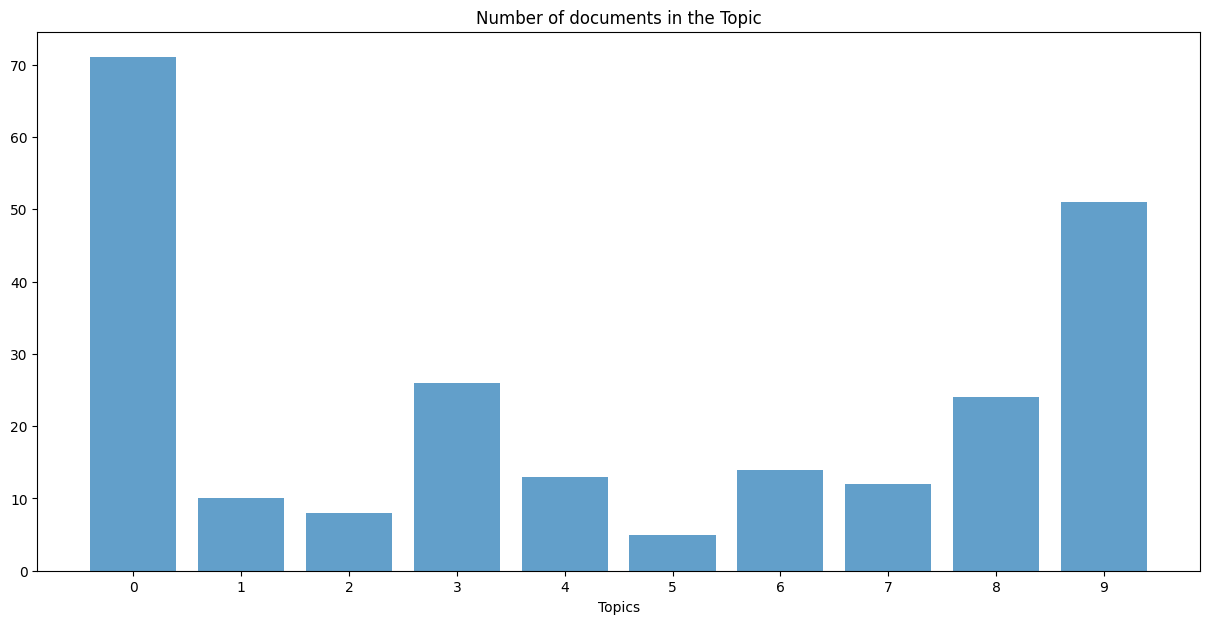

In [766]:
# coding=utf-8
from matplotlib import pyplot as plt
from matplotlib import font_manager
 
plt.figure(figsize=(15,7)) 
plt.bar(range(num_topics),topic_num_list,align='center', alpha=0.7, ecolor='black', capsize=10)
plt.xticks(range(num_topics),range(num_topics))
plt.xlabel("Topics")
plt.title('Number of documents in the Topic')
plt.show()

As can be seen above, the most common topics are 0, 9 and 3.
We attmpted to find the context of each topic by analyzing the articles in each cluster (code below).
However, we were not able to find clear distinctions between the topics and so it proved challenging to find out the exact semantic category of each cluster.

In [767]:
# tmp_dict={0:[],1:[],2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[], 13:[], 14:[], 15:[], 16:[], 17:[], 18:[], 19:[]} ## cluster_id => document_id list, tmp_dict[i] returns all documents with cluster i
tmp_dict={0:[],1:[],2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]} ## cluster_id => document_id list, tmp_dict[i] returns all documents with cluster i

for k,v in topic_document.items():
    tmp_dict[v] += [k]


In [773]:
# tmp_dict[0] ## lists all documents that have cluster 0

In [ ]:
# data_content[3] and data_content[4] belong to cluster0 but do not seem to share any semnatic similarities

## Clustering
In this section we analyze to what extent clustering can be used to find similar item sets. 
In the next section, we do a comparison where we compare the results with hashing.

In [34]:
cleaned_docs_cluster=[str([' '.join(clean(data))]) for data in data_content]

In [35]:
#Count Vectoriser then tidf transformer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(cleaned_docs_cluster)
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(X)

### Find the optimal epsilon value 
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

In [36]:
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=5).fit(tfidf.T)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(tfidf.T)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

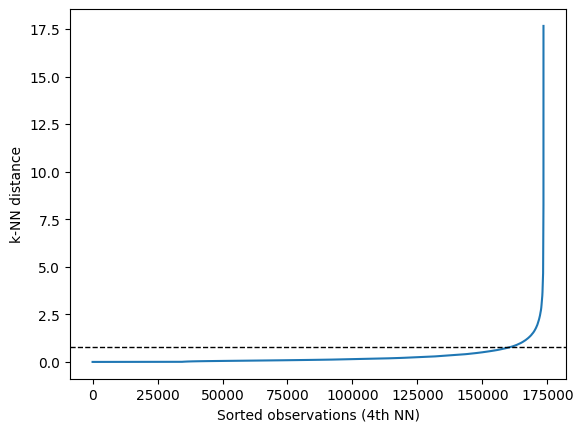

In [39]:
import matplotlib.pyplot as plt
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.axhline(y=0.8, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [40]:
eps=0.8

### Compute DBSCAN clustering

In [41]:
''' Load the stored tfidf matrix '''
with open("tfidf.pickle", "rb") as handle:
    tfidf = pickle.load(handle)

In [42]:
# eps = 0.8
import scipy
km = DBSCAN(eps=eps, min_samples=5)
km.fit(tfidf)
print(km.labels_)
clusters = km.labels_.tolist()

[-1 -1 -1 ... -1 -1 -1]


In [43]:
print("number of clusters", len(list(set(clusters))))

number of clusters 132


In [44]:
plag_articles_clustering = [i for i in range(len(clusters)) if clusters[i]!=-1] ## gives the list of plagiarised articles

In [45]:
# count of plagirized documents 
from collections import Counter
count = Counter(clusters)
print("number of plagiarised articles", sum([count[item] for item in count if item!=-1])) # not counting the -1 cluster 
count_dic = dict(sorted(count.items()))
del count_dic[-1] ## remove -1 keys 

number of plagiarised articles 1489


As can be seen exactly 1489 documents have been clustered into 132 clusters out of the original 50000. Next we shall make some plots to analyze further the results.

### Plotting number of articles per cluster

<BarContainer object of 131 artists>

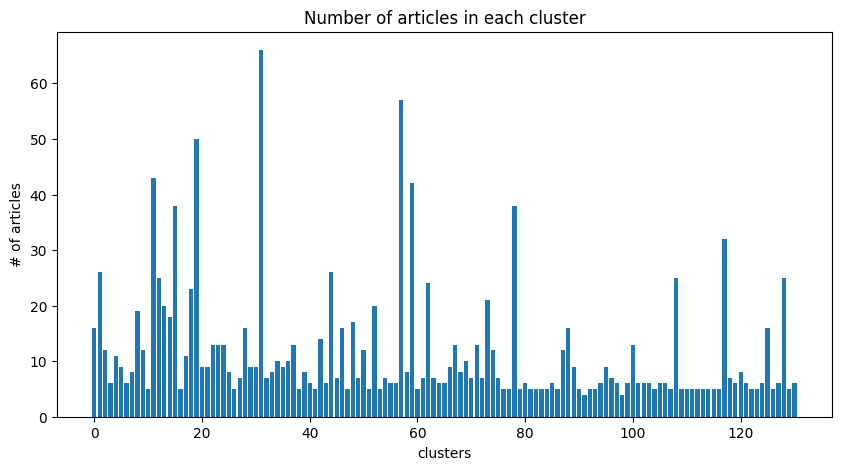

In [46]:
plt.figure(figsize=(10,5))
plt.ylabel('# of articles')
plt.title('Number of articles in each cluster')
plt.xlabel('clusters')

plt.bar(count_dic.keys(), count_dic.values())

As we can see each cluster has a lot of documents. This also shows the difficulty of using clustering as a similarity finding technique. As opposed to hashing, where we would have maybe 2 or 3 items per pair, here if we consider each cluster to be a pair we have a range of different documents. So it is natural to assume that performance would be low. It might be possible to adjust hyperparameters to tune the number of points in each cluster but that is beyond the scope of this project.

Non trivial to remove rows from scipy sparse matrix.
Therefore code from https://stackoverflow.com/questions/13077527/is-there-a-numpy-delete-equivalent-for-sparse-matrices

In [47]:
import scipy
def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]

In [48]:
print(tfidf.shape)
print(len(km.labels_))
indices = np.where(km.labels_ == -1)[0]

(50000, 173525)
50000


In [49]:
new_tfidf=delete_rows_csr(tfidf.copy(), indices)

### Visualization of DBSCAN clustering

In [50]:
# convert multidimentional data to 2 dim 
X_embedded = TSNE(n_components=2).fit_transform(new_tfidf)
x=X_embedded[:,0]
y=X_embedded[:,1]

c:\Users\hasee\pyenvs\comptools\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hasee\pyenvs\comptools\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [51]:
# indices = np.where(km.labels_==-1)
km.labels_ = np.delete(km.labels_, indices)

In [52]:
import plotly.express as px
    
fig = px.scatter(tfidf, x=x, y=y, color = km.labels_, size_max=60)

fig.update_layout(
     height=800)
fig.show()

As can be seen we nice result from clustering. In the next section we look at the Jaccard similarity of the items that have been clustered but which are different from the items found from hashing.

## Comparisons

In this section, we do a comparison of the minhashing and clustering implementations.


1) Hashing returned news articles in 2-wise and 3-wise pairs, but we have no control over how many items appear in clusters, therefore it is not possible to directly compare pairs. To get around this, we instead flatten the arrays and look at each article individually. We find out how many are similar across the two techniques.

2) In each cluster, we create pairs of teh documents present and for each we compute the jaccard similarity. We filter the score and check the documents that have a similarity score above 0.9. This allows us to assess to what extent clustering can be used to find similar item pairs.


In [53]:
lst_plag_news_int=[int(item) for item in lst_plag_news] ## convert to int for set intersection to work
intersection_hash_clust = set(lst_plag_news_int) & set(plag_articles_clustering)
intersection_hash_clust

{3823,
 10156,
 13009,
 15467,
 15721,
 16256,
 16723,
 18344,
 18372,
 19020,
 19303,
 20083,
 21435,
 21751,
 21869,
 22175,
 23227,
 23668,
 23915,
 23998,
 24229,
 24407,
 24571,
 24821,
 25721,
 26098,
 26305,
 26578,
 27360,
 27843,
 27872,
 28270,
 28582,
 28788,
 28834,
 29463,
 29813,
 30000,
 30057,
 30226,
 30320,
 30610,
 30613,
 30751,
 30936,
 30977,
 39869,
 40126,
 41650,
 41653,
 41759,
 41771,
 41844,
 41926,
 42038,
 42166,
 42288,
 42351,
 42367,
 42460,
 42566,
 42588,
 42605,
 42669,
 42681,
 42746,
 42783,
 42878,
 42900,
 42957,
 42981,
 42996,
 43085,
 43099,
 43204,
 43408,
 43456,
 43487,
 43515,
 43824,
 44031,
 44325,
 44410,
 44440,
 44504,
 44514,
 44582,
 44608,
 44834,
 44928,
 45125,
 45215,
 45258,
 45275,
 45285,
 45336,
 45341,
 45365,
 45403,
 45438,
 45449,
 45455,
 45465,
 45488,
 45517,
 45537,
 45548,
 45604,
 45609,
 45639,
 45650,
 45695,
 45730,
 45739,
 45887,
 45945,
 45949,
 46040,
 46087,
 46218,
 46253,
 46377,
 46389,
 46403,
 46503,
 

We see that there are a number of documents that appear in both lists.
Next, we look at the Jaccard similarities for documents in each cluster.

In [54]:
''' Create dictionary that has a mapping from cluster ids to document ids 
    If the cluster id has not been found before, insert a new key value pair in the dictionary with value equal to empty array
    Append to the list for each cluster id the document that has that cluster id.
'''
index_to_doc={}
for i in range(len(clusters)):
    if clusters[i] == -1:
        continue
    if clusters[i] not in index_to_doc.keys():
        index_to_doc[clusters[i]] = []
    index_to_doc[clusters[i]] += [i]


In [116]:
''' Generate pairs for documents in each cluster '''
dic={}
import itertools
for clusterid, val in index_to_doc.items():
    dic[clusterid] = itertools.combinations(index_to_doc[clusterid], 2)

list(dic[0]) ## list document pairs belonging to cluster0


[(74, 781),
 (74, 1504),
 (74, 1754),
 (74, 1835),
 (74, 2887),
 (74, 2981),
 (74, 3632),
 (74, 3956),
 (74, 4970),
 (74, 5412),
 (74, 6816),
 (74, 6902),
 (74, 7496),
 (74, 7646),
 (74, 10409),
 (781, 1504),
 (781, 1754),
 (781, 1835),
 (781, 2887),
 (781, 2981),
 (781, 3632),
 (781, 3956),
 (781, 4970),
 (781, 5412),
 (781, 6816),
 (781, 6902),
 (781, 7496),
 (781, 7646),
 (781, 10409),
 (1504, 1754),
 (1504, 1835),
 (1504, 2887),
 (1504, 2981),
 (1504, 3632),
 (1504, 3956),
 (1504, 4970),
 (1504, 5412),
 (1504, 6816),
 (1504, 6902),
 (1504, 7496),
 (1504, 7646),
 (1504, 10409),
 (1754, 1835),
 (1754, 2887),
 (1754, 2981),
 (1754, 3632),
 (1754, 3956),
 (1754, 4970),
 (1754, 5412),
 (1754, 6816),
 (1754, 6902),
 (1754, 7496),
 (1754, 7646),
 (1754, 10409),
 (1835, 2887),
 (1835, 2981),
 (1835, 3632),
 (1835, 3956),
 (1835, 4970),
 (1835, 5412),
 (1835, 6816),
 (1835, 6902),
 (1835, 7496),
 (1835, 7646),
 (1835, 10409),
 (2887, 2981),
 (2887, 3632),
 (2887, 3956),
 (2887, 4970),
 (288

In [136]:
''' Iterate through the cluster ids and for each pair of documents in it, retrive the documents texts, hash them and 
    compute the jaccard sim between them. Store the results in a dictionary indexed by the cluster id.
    Do not store pairs if similarity is below 0.5 '''
j_set = {}
for k,v in index_to_doc.items():
    j_set[k]=[]
    for pair in v:
        a = [listhash(item, seed=1) for item in shingled_docs[v[0]]]
        b = [listhash(item, seed=1) for item in shingled_docs[v[1]]]
    # for item in shingle_docs[v[0]]
    # hash_pairs=(listhash(shingled_docs[v[0]], seed=1),listhash(shingled_docs[v[0]], seed=1))
        if len(set(a))==0 or len(set(b))==0:
            continue
        j_score = jaccard(set(a), set(b))
        if j_score > 0.5:
            j_set[k] += [[j_score, v[0], v[1]]]
    # jaccard_set[k] = [jaccard(set(a), set(b)), v[0], v[1]]


In [139]:
filtered_set={}
for k,v in j_set.items():
    if len(v) != 0:
        print(k, v)
        print("\n")

123 [[1.0, 43085, 43099], [1.0, 43085, 43099], [1.0, 43085, 43099], [1.0, 43085, 43099], [1.0, 43085, 43099]]


130 [[1.0, 46389, 46403], [1.0, 46389, 46403], [1.0, 46389, 46403], [1.0, 46389, 46403], [1.0, 46389, 46403], [1.0, 46389, 46403]]




As can be seen above, there are a few items with a score of 1.0 but most have a jaccard similarity of around 0

Next, we see how many document pairs have jaccard similarity of above 50

As can be seen, exactly 2 pairs have a similarity of more than 0.5. Namely pairs 123 and 130

In [62]:
assert data_content[46389]==data_content[46403]
assert data_content[43099]==data_content[43085]

Looking at the results above, we see that are indeed exactly identical.

 ## Conclusion
 We were indeed able to find similar news articles using a package version of LSH. 191 pairs were found to be similar. However, our own implementation did not work quite so well yielding only 36 articles. This could be attributed to using only a single hash function in the algorithm. Also, we were able to easily extract semantic information on topics formed during topic modelling proving it hard to pinpoint exactly which topics are most plagiarised. Finally, we showed that using DBSCAN clustering we were able to find atleast two sets of articles that were exactly similar. However, plotting the jaccard similarity of the clustered data points showed that perhaps it is not the best technique to find similar items and more mainstream methods such as minhashing should be used. It must also be noted that it is possible to use DBSCAN with Jaccard score as a distance metric. However, that required a reshaping of the data since it does not take sparse matrices as input and was therefore beyond the scope of this project.